In [11]:
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
from scipy.stats import loguniform
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [1]:
def feature_engineering(df):
    df['hour'] = df.date.dt.hour
    df['day'] = df.date.dt.day
    df['dayofweek'] = df.date.dt.dayofweek
    df['day_name'] = df.date.dt.day_name()
    df['month'] = df.date.dt.month
    df['month_name'] = df.date.dt.month_name()
    df['quarter'] = df.date.dt.quarter
    df['year'] = df.date.dt.year
    df["weekofyear"] = df.date.dt.weekofyear
    df['is_month_start'] = df.date.dt.is_month_start.astype(float)
    df['is_month_end'] = df.date.dt.is_month_end.astype(float)
    df['is_year_start'] = df.date.dt.is_year_start.astype(float)
    df['is_year_end'] = df.date.dt.is_year_end.astype(float)
    return df

In [2]:
def make_shift(df):
    df['lag_23'] = df['value'].shift(23)
    df['lag_24'] = df['value'].shift(24)
    df['lag_25'] = df['value'].shift(25)
    df['lag_m23'] = df['value'].shift(-23)
    df['lag_m24'] = df['value'].shift(-24)
    df['lag_m25'] = df['value'].shift(-25)
    return df

In [4]:
def make_ohe_lebels(df):
    oneHotEncoder = OneHotEncoder()
    X_ohe = oneHotEncoder.fit_transform(df_full[['dayofweek','month', 'year']])
    
    ohe_labels = list(df.day_name.unique()[4:]) 
    ohe_labels += list(df.day_name.unique()[:4])
    ohe_labels += list(df.month_name.unique()[10:])  
    ohe_labels += list(df.month_name.unique()[:10])
    ohe_labels += list(df.year.unique().astype(np.str))
    
    return pd.DataFrame(X_ohe.toarray(), index=df_full.index, columns=ohe_labels)

In [7]:
def train_full_and_predict(df_full, train_columns, model):
    test_value_change = df_full.value.mean()
    lag_value_change = df_full.value.mean()
    
    X_change = df_full.copy()
    X_change = X_change.fillna(test_value_change)
    X_change = make_shift(X_change)
    X_change = X_change.fillna(lag_value_change)
    
    df_train = X_change.iloc[train_index]
    df_test  = X_change.iloc[test_index]
    
    X_train = df_train[train_columns]
    y_train = df_train["value"]
    X_test  = df_test[train_columns]
    
    model.fit(X_train, y_train)
    print(mae(y_train, model.predict(X_train)))
    
    return model.predict(X_test)

In [8]:
def test_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    X_train = df_full.iloc[train_index]
    X_test = df_full.iloc[test_index]
    start_day = np.where(np.arange(len(train_index))%24 == 0)[0]

    for train_idx, test_idx in tqdm(cv.split(start_day)):

        test_id = []
        for start_h in start_day[test_idx]:
            for i in range(24):
                test_id.append(start_h+i)
        if 26517 in test_id: test_id.remove(26517)
        if 26518 in test_id: test_id.remove(26518)
        if 26519 in test_id: test_id.remove(26519)

        train_id = []
        for start_h in start_day[train_idx]:
            for i in range(24):
                train_id.append(start_h+i)
        if 26517 in train_id: train_id.remove(26517)
        if 26518 in train_id: train_id.remove(26518)
        if 26519 in train_id: train_id.remove(26519)

        test_value_change = X_train.iloc[train_id].value.mean()
        lag_value_change = X_train.iloc[train_id].value.mean()

        X_change = X_train.copy()
        y_train_tmp, y_test_tmp = X_change.iloc[train_id].value, X_change.iloc[test_id].value
#         X_change.iloc[test_id, X_change.columns.get_loc('value')] = test_value_change
        X_change = make_shift(X_change)
        X_change = X_change.fillna(lag_value_change)
        X_train_tmp, X_test_tmp = X_change.iloc[train_id][train_columns], X_change.iloc[test_id][train_columns]
        
        model.fit(X_train_tmp, y_train_tmp)
        y_pred = model.predict(X_test_tmp)
        score = mae(y_test_tmp, y_pred)
        scores.append(score)

    print(np.mean(scores), np.std(scores))

In [6]:
train_columns = ['hour', 
                 'is_month_start',   'is_month_end',  
                 'is_year_start', 'is_year_end',
                 'weekofyear', 
                 'quarter',
                 'Monday','Tuesday','Wednesday', 'Thursday','Friday','Saturday','Sunday',
                 'January','February', 'March','April','May','June','July','August','September','October', 'November','December',
                 '2018','2019','2020','2021','2022', 
                 'lag_23', 'lag_24', 'lag_25', 
                 'lag_m23', 'lag_m24', 'lag_m25'
                ]

## First solution -> 457.86671

In [ ]:
df_train = pd.read_hdf("../input/energy_train.h5")
df_test = pd.read_hdf("../input/energy_test.h5")

In [ ]:
test_index = list(df_test.index)
train_index = list(df_train.index)

In [ ]:
df_full = pd.concat([df_train, df_test])
df_full = df_full.sort_values(by=['id'])

In [ ]:
df_full = feature_engineering(df_full)
df_ohe = make_ohe_df(df_full)

df_full = df_full.join(df_ohe)

In [ ]:
model = RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs = -1, random_state=42)
y_test_pred = train_full_and_predict(df_full, train_columns, model)

In [ ]:
df_out = pd.DataFrame(data=y_test_pred, index=test_index, columns=['value'])
df_out.index.name = 'id'
df_out.to_csv("../output/rfr8.csv")

## Final solution -> 373.35602

In [ ]:
df_train = pd.read_hdf("../input/energy_train.h5")
df_test = pd.read_hdf("../input/energy_test.h5")

### Rozszerzenie zbioru danych poprzednimi predykcjami

In [ ]:
for i in range(8, 21):
    df_train = pd.read_hdf("../input/energy_train.h5")
    df_test = pd.read_hdf("../input/energy_test.h5")

    df_test_y = pd.read_csv(f"../output/rfr{i}.csv").set_index('id')
    df_test_y.index.name = None
    df_test = df_test.join(df_test_y)

    test_index = list(df_test.index)
    train_index = list(df_train.index)

    df_full = pd.concat([df_train, df_test])
    df_full = df_full.sort_values(by=['id'])

    df_full = feature_engineering(df_full)
    df_ohe = make_ohe_df(df_full)

    df_full = df_full.join(df_ohe)

    model = RandomForestRegressor(max_depth=20, n_estimators=500, n_jobs = -1, random_state=42)
    y_test_pred = train_full_and_predict(df_full, train_columns, model)

    df_out = pd.DataFrame(data=y_test_pred, index=test_index, columns=['value'])
    df_out.index.name = 'id'
    df_out.to_csv(f"../output/rfr{i+1}.csv")

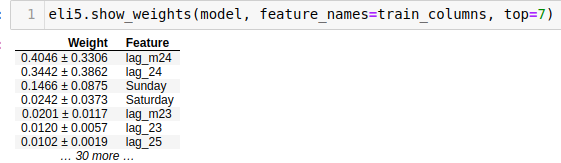